In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # Added import for FuncFormatter

import seaborn as sns
sns.set(
    { "figure.figsize": (8, 5) },
    style='ticks',
    color_codes=True,
    font_scale=1
)
%config InlineBackend.figure_format = 'retina'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

!pip install category_encoders -q
!pip install xgboost

# ML utilities
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn import metrics

# Models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Encoding and metrics
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [17]:
df = pd.read_csv("../data/Dataset_ecommerce.csv")

In [18]:
df.head(2)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali


In [19]:
df.shape

(541909, 8)

In [20]:
#check for more info on df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   InvoiceDate  541909 non-null  object 
 2   CustomerID   406829 non-null  float64
 3   StockCode    541909 non-null  object 
 4   Description  541909 non-null  object 
 5   Quantity     541909 non-null  int64  
 6   UnitPrice    541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [21]:
#Descriptive stat
df.describe(include ="all")

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
count,541909,541909,406829.000000,541909,541909,541909.000000,541909.000000,541909
unique,25900,23260,NaN,9000,10,NaN,NaN,28
top,573585,2011-10-31 14:41:00,NaN,SC2014,Sports Equipment,NaN,NaN,Cote d'Ivoire
freq,1114,1114,NaN,96,54765,NaN,NaN,19651
mean,NaN,NaN,15287.690570,NaN,NaN,50.534748,50.476354,NaN
std,NaN,NaN,1713.600303,NaN,NaN,28.849367,28.564775,NaN
min,NaN,NaN,12346.000000,NaN,NaN,1.000000,1.000000,NaN
25%,NaN,NaN,13953.000000,NaN,NaN,26.000000,25.750000,NaN
50%,NaN,NaN,15152.000000,NaN,NaN,51.000000,50.430000,NaN
75%,NaN,NaN,16791.000000,NaN,NaN,76.000000,75.180000,NaN


In [22]:
df.isnull().sum()

InvoiceNo           0
InvoiceDate         0
CustomerID     135080
StockCode           0
Description         0
Quantity            0
UnitPrice           0
Country             0
dtype: int64

In [23]:
df.dropna(inplace = True)

In [24]:
#convert to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.head(5)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda


In [25]:
# Create Total Price Column 
df["TotalPrice"] = df["UnitPrice"] * df["Quantity"]

In [26]:
# Checking Unique values in the columns
print("Unique_Customers:", df['CustomerID'].nunique())
print("Unique_Products:", df['StockCode'].nunique())
print("Countries:", df['Country'].nunique())

Unique_Customers: 4372
Unique_Products: 9000
Countries: 28




# Exploratory Data Analysis


### sales trend visualization

In [29]:
# sales trend over time 
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()

In [30]:
monthly_sales

InvoiceDate
2010-12    6.792367e+07
2011-01    5.582933e+07
2011-02    5.208536e+07
2011-03    7.137210e+07
2011-04    5.914003e+07
2011-05    7.434151e+07
2011-06    7.109639e+07
2011-07    7.040789e+07
2011-08    6.994326e+07
2011-09    1.036281e+08
2011-10    1.287425e+08
2011-11    1.677331e+08
2011-12    4.519251e+07
Freq: M, Name: TotalPrice, dtype: float64

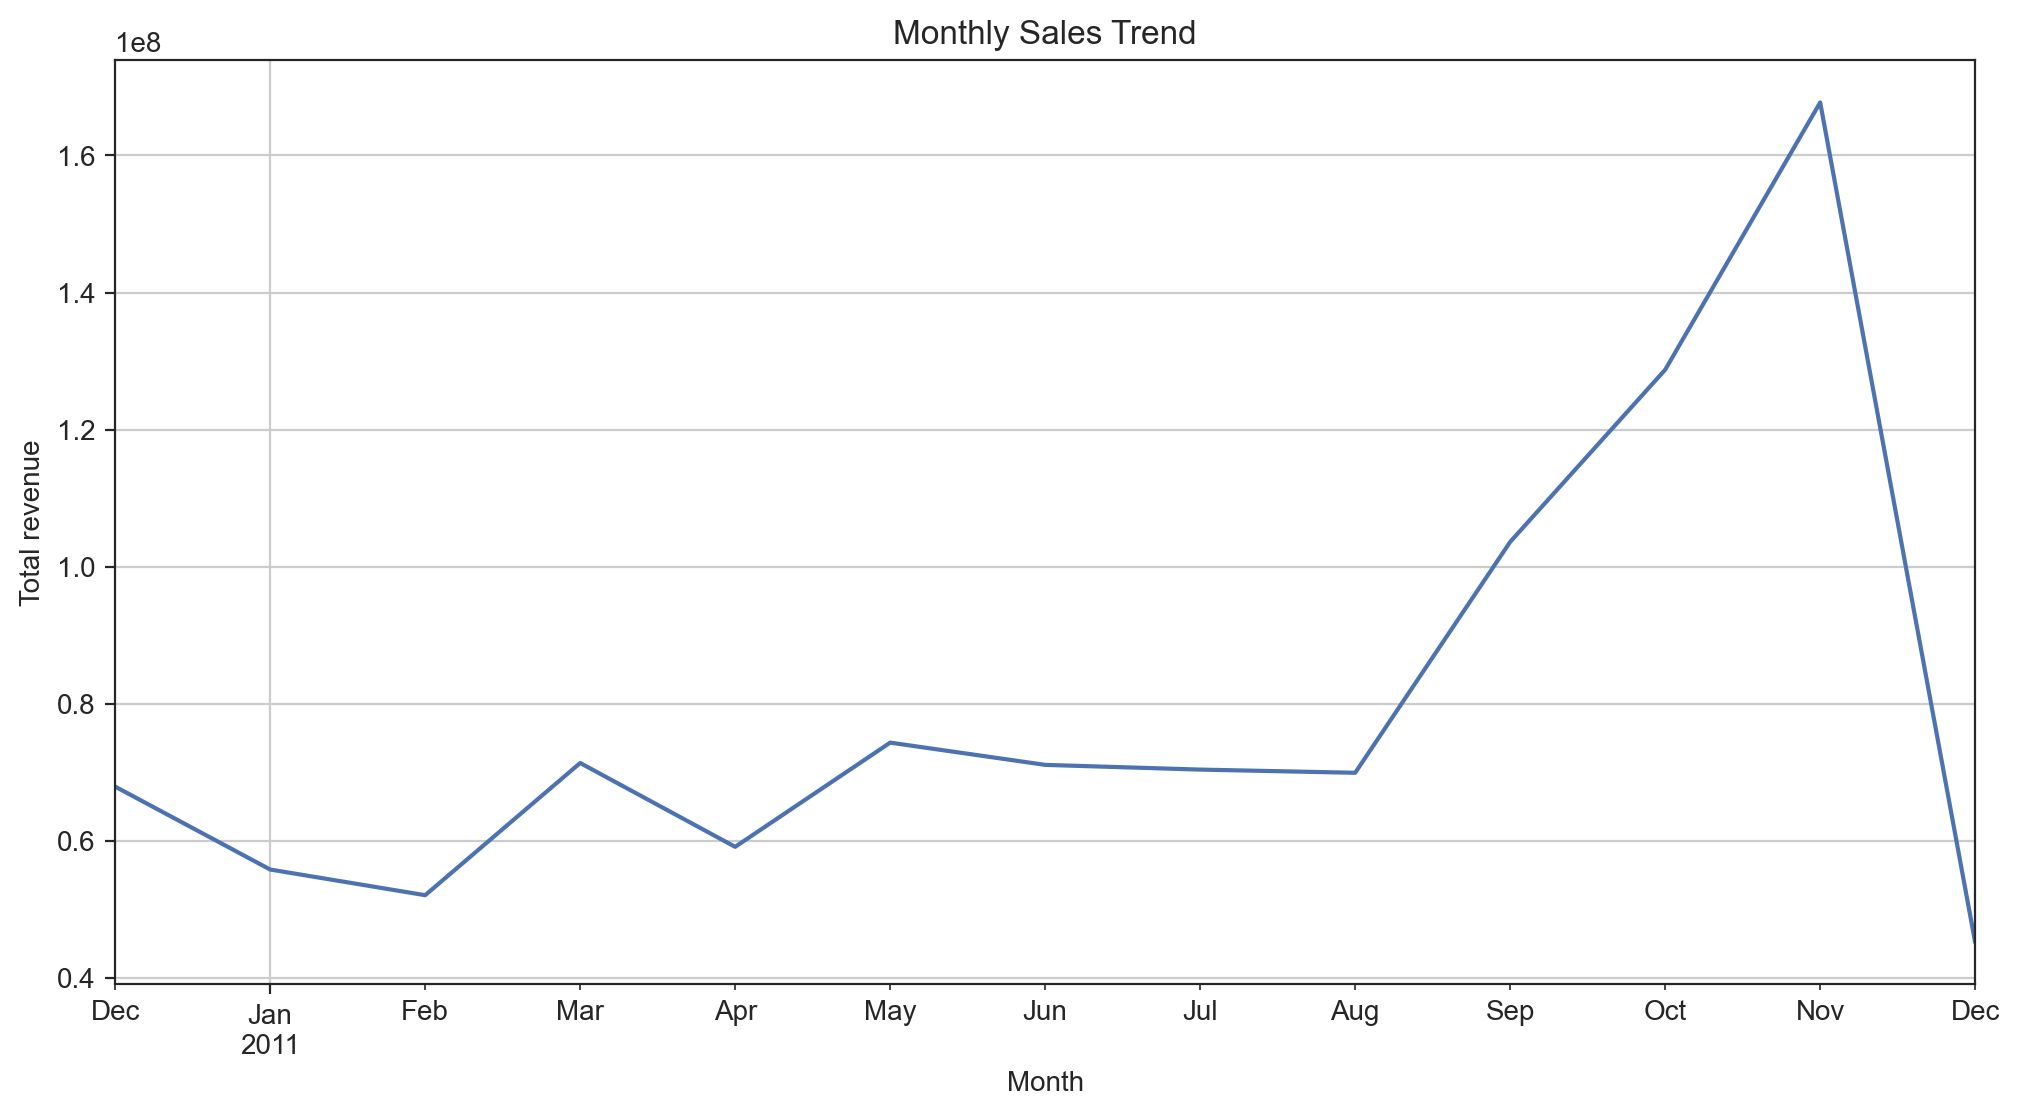

In [31]:
# create folder one level up
import os
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualizations')
os.makedirs(output_dir,exist_ok=True)
# Create a line chart and save 

plt.figure(figsize=(12, 6))
monthly_sales.plot()
plt.xlabel('Month')
plt.ylabel('Total revenue')
plt.title('Monthly Sales Trend')
plt.grid(True)

#save as png
output_path = os.path.join(output_dir, 'monthly_sales_trend.png')

# Display the plot
plt.show()

Sales Trend Obsrvations

* Initial Dip: sales declined from December through february hiting a low in february.
* Moderate recovery: There was a slight growth in sales from March and May followed by a flat trend from June to August.
* Strong Growth: There was a sharp increase in revenue from September to November,with November being the peak month.
* Sharp drop : There was a significant decline in revenue after the peak period, which is likely a result of seasonal closure or end of data collection.

## Top Selling Products

In [34]:
#Top selling products 
#Total quantity sold per product
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)


In [35]:
top_products

Description
Shoes               2069190
Jewelry             2065153
Toys                2063396
Furniture           2063221
Sports Equipment    2060571
Cloths              2054709
Cosmetics           2051088
Kitchenware         2046704
Electronics         2036733
Books               2025341
Name: Quantity, dtype: int64

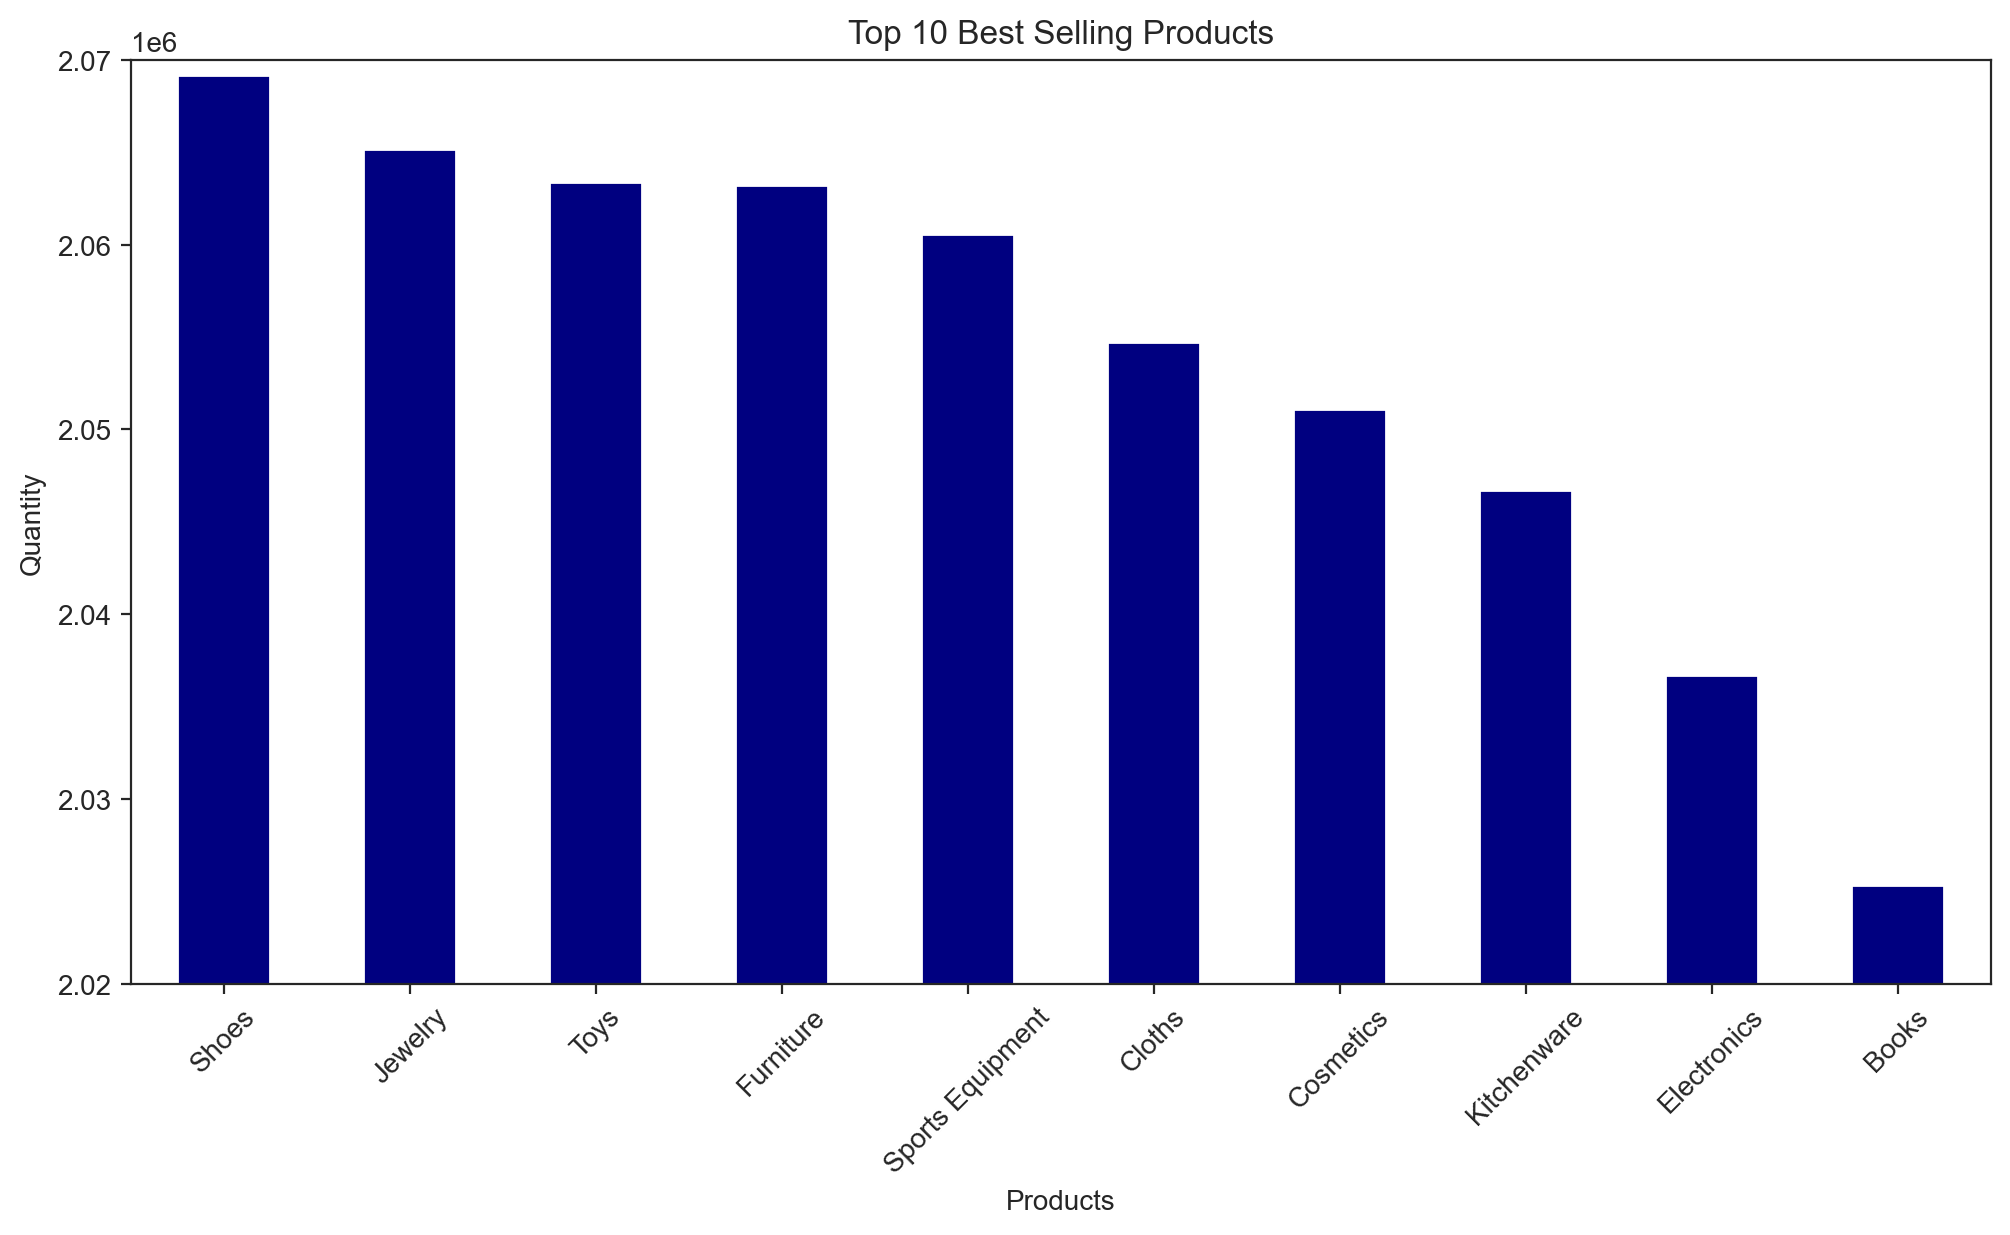

In [36]:
# create folder one level up

output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualizations')
os.makedirs(output_dir,exist_ok=True)

#plot
plt.figure(figsize=(12, 6))
top_products.plot(kind= "bar", color='navy')
plt.xlabel('Products')
plt.ylabel('Quantity')
plt.title('Top 10 Best Selling Products')
plt.xticks(rotation =45 )
plt.ylim(2.02e6, 2.07e6)

#save as png
output_path = os.path.join(output_dir, 'Top_10_Best_Selling_Products.png')

# Display the plot
plt.show()

### Top 10 Best-Selling Products- key Insights
* **Narrow Sales Range**: All top 10 products have sales quantities indicating a very tight clustering of performance
* **Leading Product** : Shoes appears to be the best-selling item, with sales slightly exceeding 2.06 million units.
* **Minimal Variation**: There's remarkably little difference in sales performance among these top products, suggesting they might be complementary items or variations of similar products.
* **Consistent Performance**: The top 10 products show a gradual decline in sales rather than any dramatic drops, indicating consistent consumer demand across these items.


## Customer Activities 

In [39]:
df['CustomerID'].nunique(),df['InvoiceNo'].nunique()

(4372, 22190)

In [40]:
df.groupby('CustomerID')['InvoiceNo'].nunique().max()

248

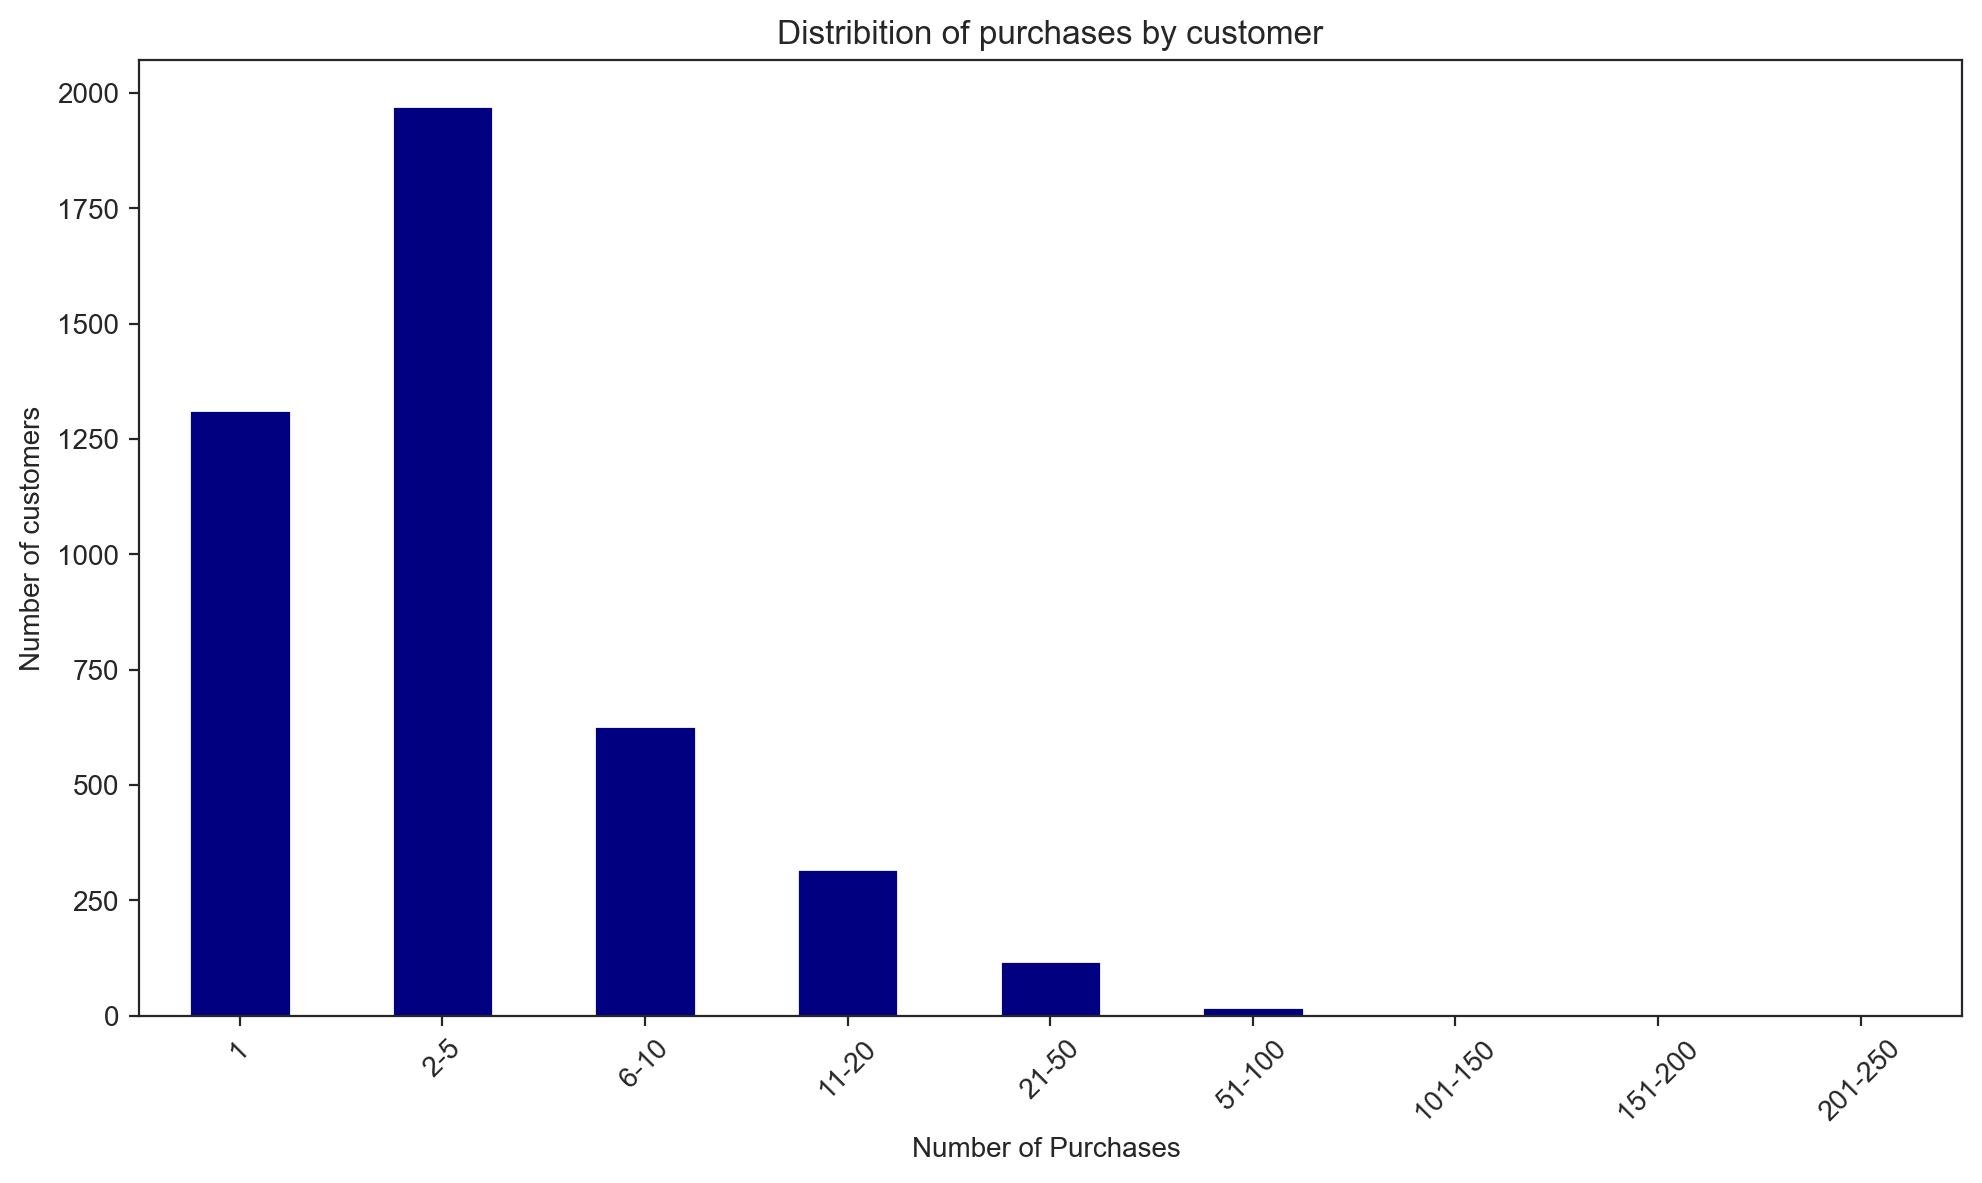

In [41]:
#count unique purchases per customer 
customer_purchases = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_purchases

#create folder one levelmup if it doesn't exist
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualizations')
os.makedirs(output_dir,exist_ok=True)

#Bin the number of purchases into ranges
bins =[0, 1, 5,10,20,50,100,150,200,250]
labels = [ '1', '2-5','6-10', '11-20', '21-50','51-100','101-150','151-200','201-250']
binned = pd.cut(customer_purchases,bins=bins , labels =labels ,include_lowest=True)

#count number of customers in each bin
purchase_distribution=binned.value_counts().sort_index()

#plot
plt.figure(figsize=(10, 6))
purchase_distribution.plot(kind= "bar", color='navy')
plt.xlabel('Number of Purchases ')
plt.ylabel('Number of customers')
plt.title('Distribition of purchases by customer')
plt.xticks(rotation =45 )
plt.tight_layout()

#save as png(after plotting )
output_path = os.path.join(output_dir, 'Distribition of purchases by customer.png')

# Display the plot
plt.show()


### Distribution of Purchases by customers- Insight from the plot
* This distribution follows what appears to be a typical "long tail" pattern in customer purchasing behavior, where a large number of customers make very few purchases, while only a small number of customers are highly active/frequent purchasers. This insight could be valuable for developing customer retention strategies, as it suggests focusing efforts on converting one-time buyers into repeat customers could have a significant impact

  

## Analysis by country 


In [44]:
quantity_per_country = df.groupby(["Country"])["Quantity"].sum().reset_index()
quantity_per_country = quantity_per_country.sort_values ("Quantity",ascending = False).reset_index()

In [45]:
#Visualize top 10 countries by sales
top_10_countries_by_sales= quantity_per_country.head(10)
top_10_countries_by_sales

,index,Country,Quantity
0,23,Togo,741223
1,20,South Africa,740589
2,4,Cote d'Ivoire,740229
3,15,Nigeria,739708
4,9,Libya,739206
5,1,Benin,738133
6,27,Zimbabwe,737522
7,19,Somalia,736219
8,0,Algeria,736181
9,18,Sierra Leone,735477


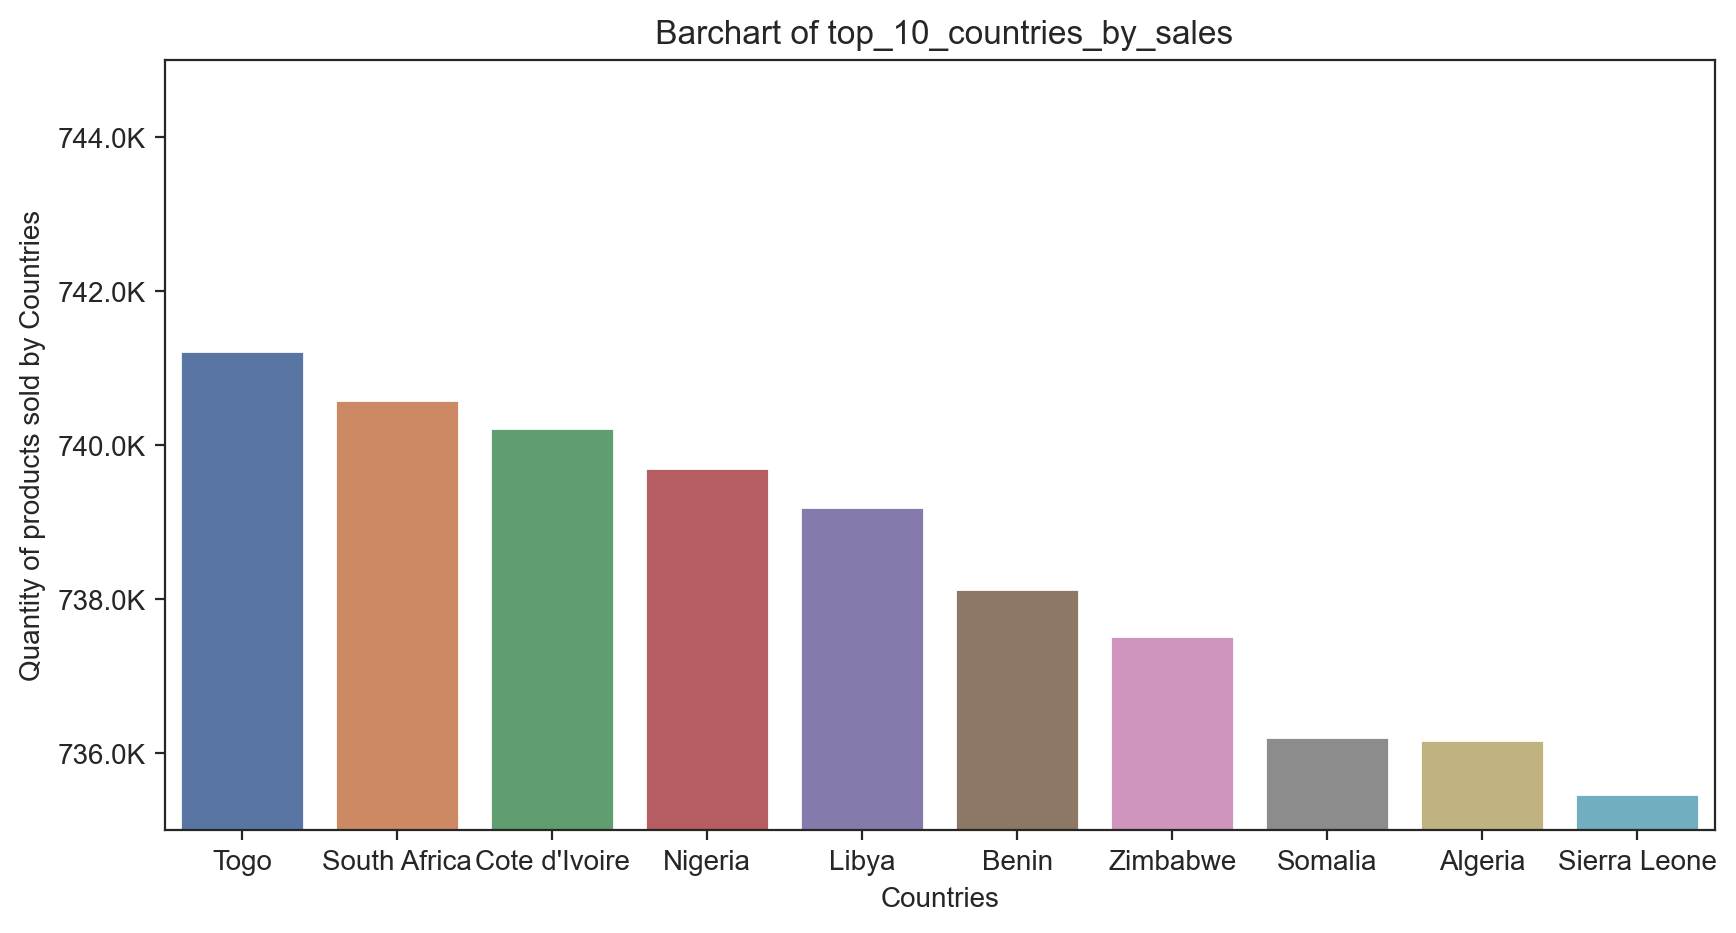

In [46]:
## Barchart of top_10_countries_by_sales

#create folder one levelmup if it doesn't exist
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualizations')
os.makedirs(output_dir,exist_ok=True)


plt.figure(figsize=(10,5)) 

y_format = FuncFormatter(lambda x, _: f'{x / 1000:.1f}K')

ax = sns.barplot(x = "Country", y =  "Quantity", data =top_10_countries_by_sales)

ax.yaxis.set_major_formatter(y_format)


#save as png(after plotting )
output_path = os.path.join(output_dir, 'top_10_countries_by_sales.png')

plt.ylim(735000, 745000) 


plt.xlabel("Countries")
plt.ylabel("Quantity of products sold by Countries")
plt.title(" Barchart of top_10_countries_by_sales")
plt.show()

### Distribution of sales by Top 10 countries - Insight from the plot
* This distribution follows what appears to be a typical "long tail" pattern in quantity of products sold by countries. With the most number for sales coming from Togo 


In [48]:
#Visualize least_10_countries_by_sales 

least_10_countries_by_sales = quantity_per_country.tail(10)

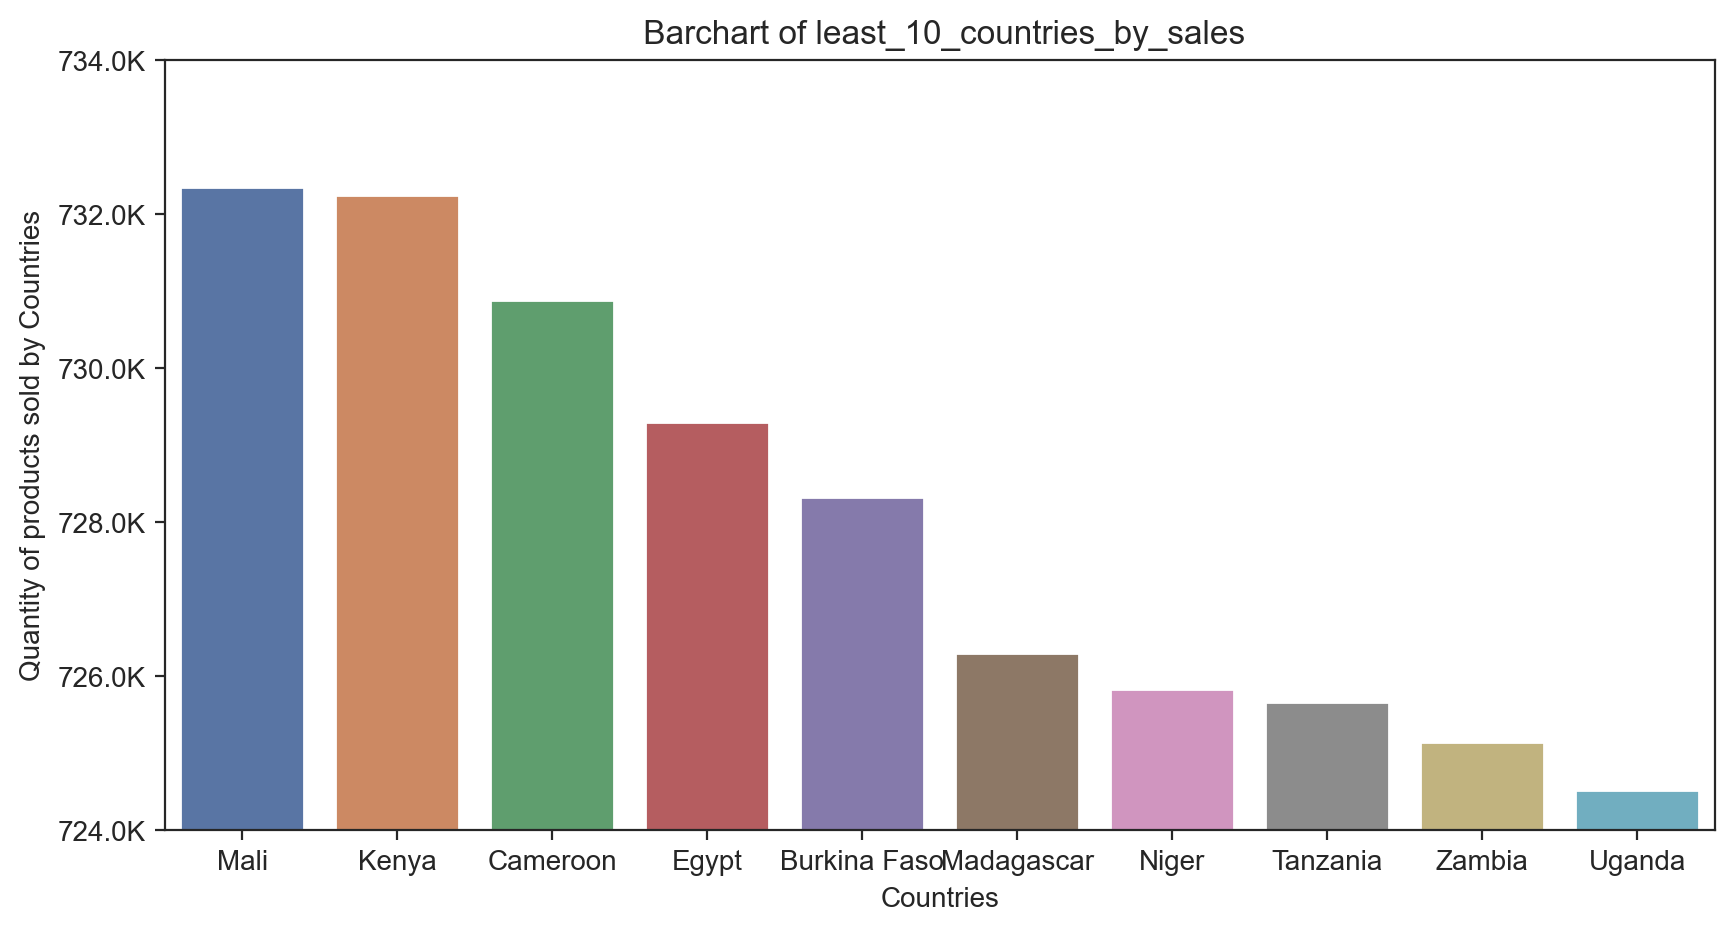

In [49]:
#Barchart of last_10_countries_by_sales

#create folder one levelmup if it doesn't exist
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualizations')
os.makedirs(output_dir,exist_ok=True)


plt.figure(figsize=(10,5)) 

y_format = FuncFormatter(lambda x, _: f'{x / 1000:.1f}K')

ax = sns.barplot(x = "Country", y =  "Quantity", data =least_10_countries_by_sales)

ax.yaxis.set_major_formatter(y_format)

plt.ylim(724000, 734000) 

#save as png(after plotting )
output_path = os.path.join(output_dir, 'least_10_countries_by_sales.png')

plt.xlabel("Countries")
plt.ylabel("Quantity of products sold by Countries")
plt.title(" Barchart of least_10_countries_by_sales")


plt.show()

### Distribution by Least 10 countries by sales - Insight from the plot
* This distribution follows what appears to be a typical "long tail" pattern in quantity of products sold by countries. With the least number for sales coming from Uganda 


In [56]:
## Analysis of customer by countries
country_to_customers = df.groupby(["Country"])["CustomerID"].nunique().reset_index()
country_to_customers = country_to_customers.sort_values("CustomerID", ascending = False).reset_index()
country_to_customers.rename(columns = {"CustomerID" : "Number of customers"}, inplace = True)

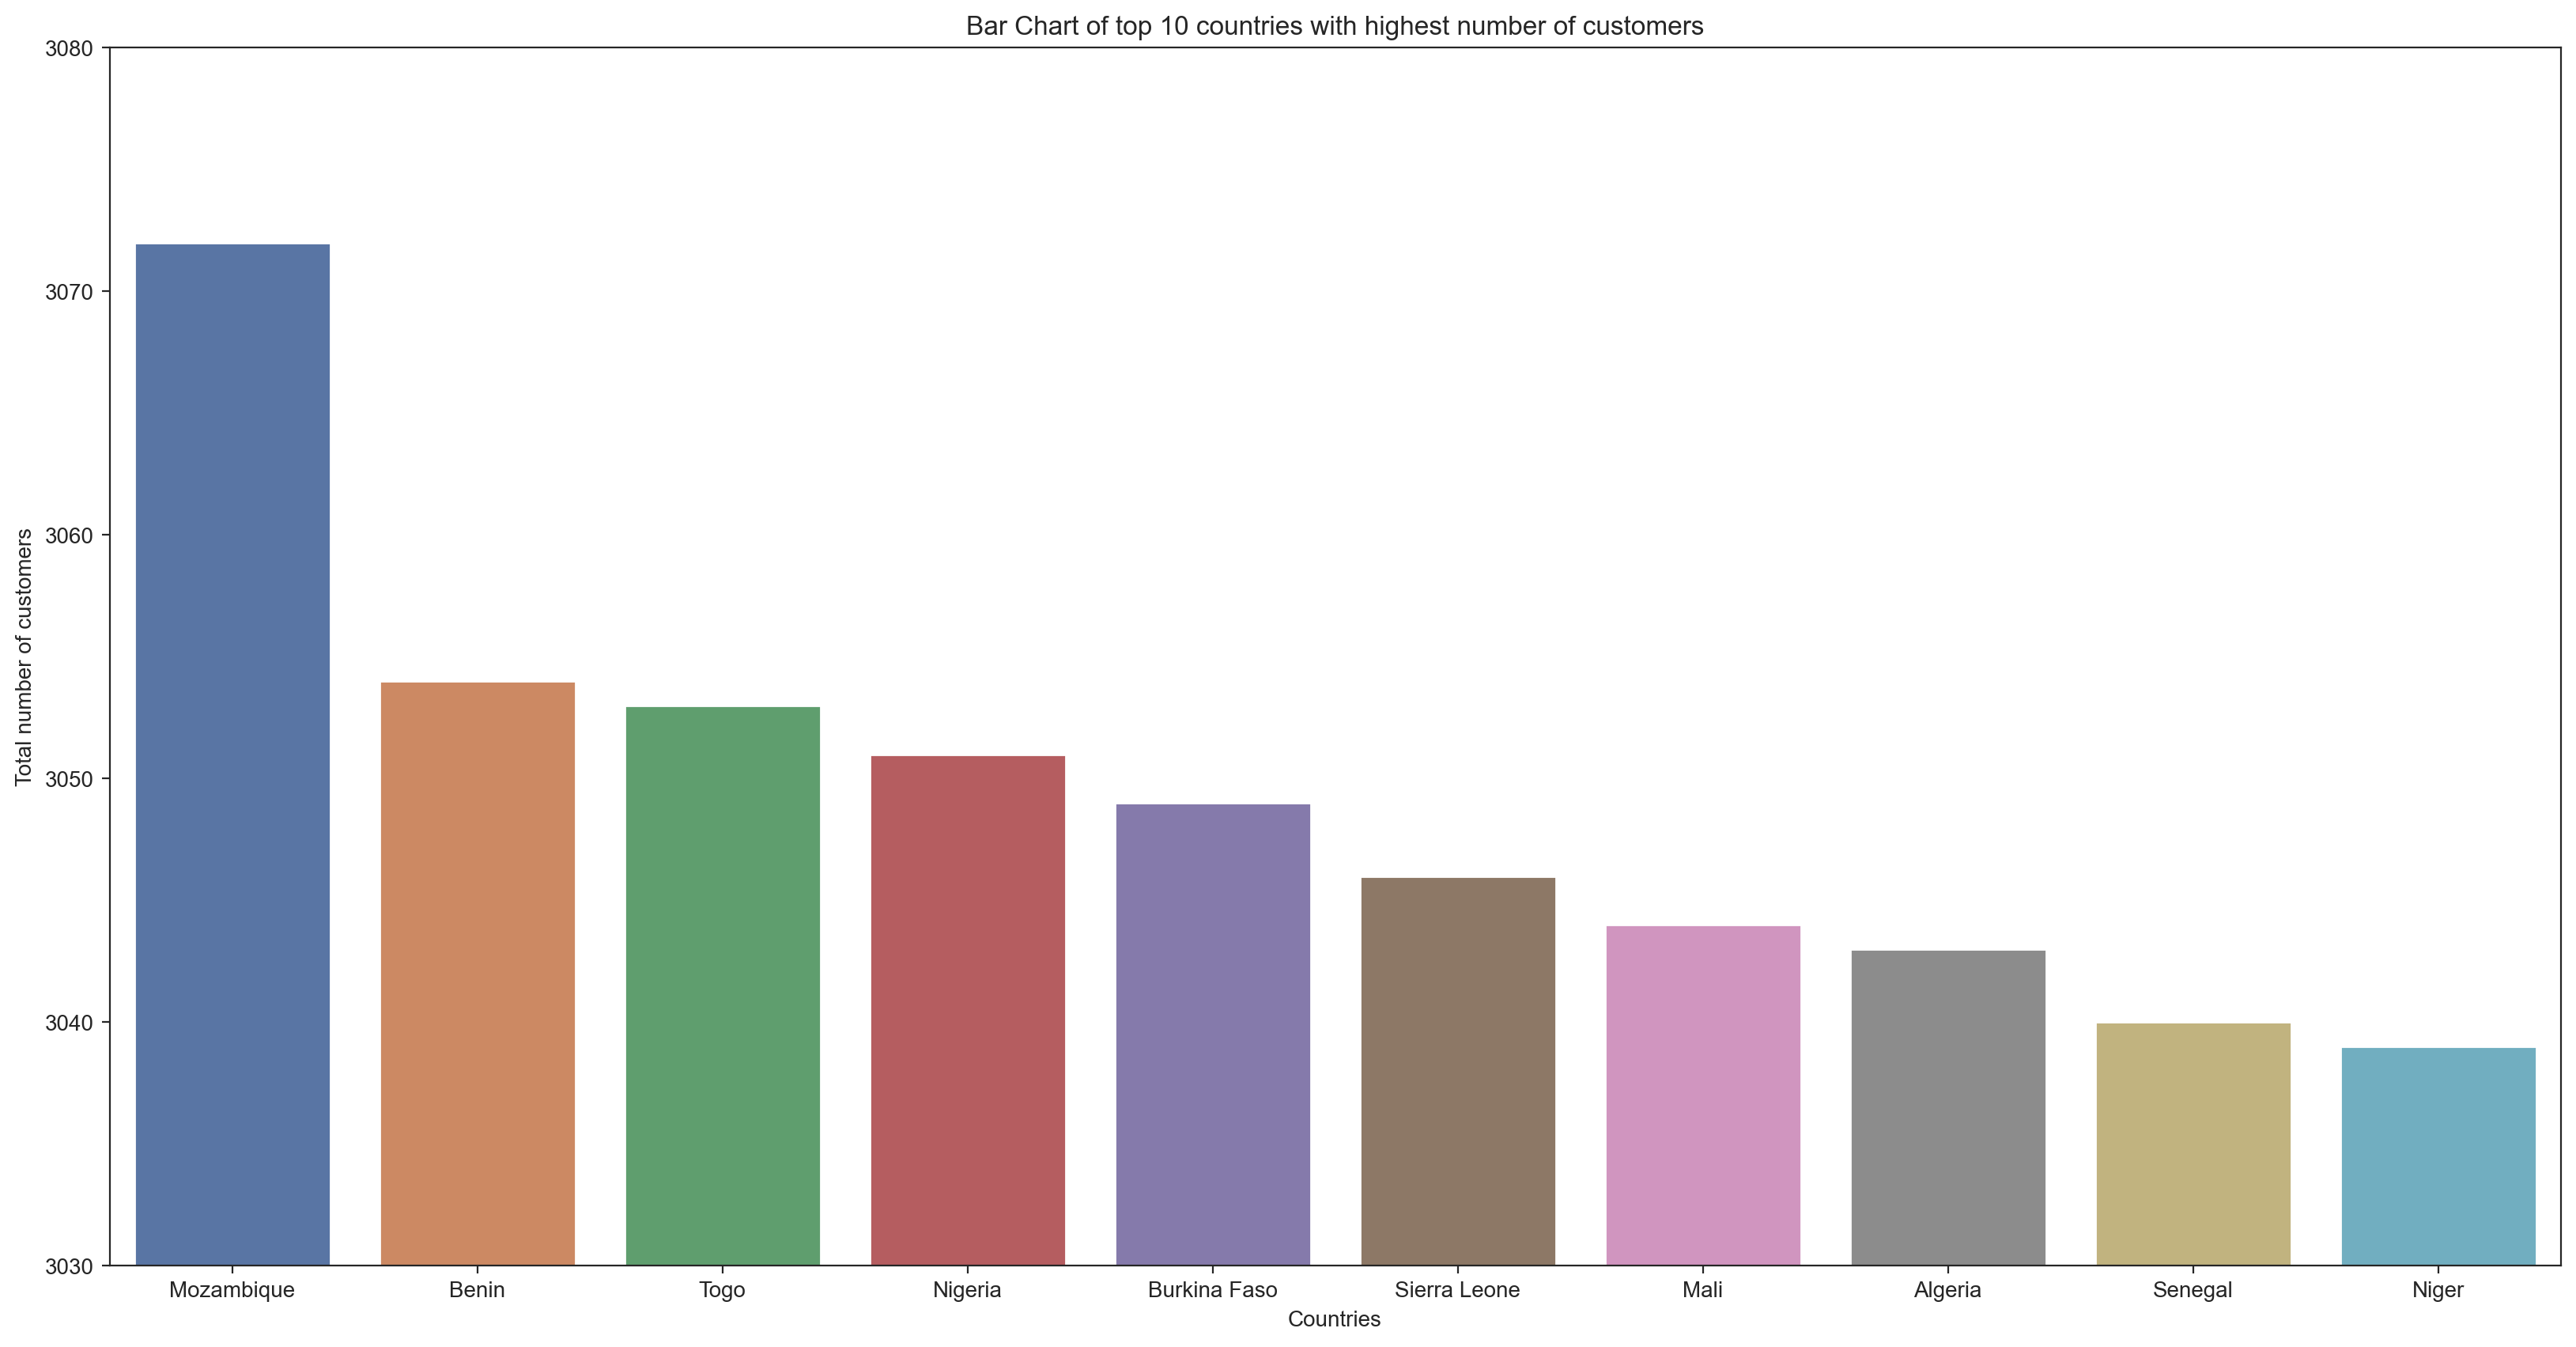

In [59]:
# Draw a plot of top 10 countries with highest number of customers (unique customerID)
top_countries_to_customers = country_to_customers.head(10)

#create folder one levelmup if it doesn't exist
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualizations')
os.makedirs(output_dir,exist_ok=True)

# Create a bar chart from the selected data
plt.figure(figsize=(20, 10))

sns.barplot(x='Country', y='Number of customers', data= top_countries_to_customers)

plt.ylim(3030,3080)

#save as png(after plotting )
output_path = os.path.join(output_dir, 'Bar Chart of top 10 countries with highest number of customers.png')

plt.xlabel('Countries')
plt.ylabel('Total number of customers')
plt.title('Bar Chart of top 10 countries with highest number of customers')
plt.show()

### Distribution of countries by number of customers - Insight from the plot
* This distribution follows what appears to be a typical "long tail" pattern in number of customers by countries with the most customers from Mozambique 



## Cohort Analysis

In [77]:
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,TotalPrice
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt,664.95
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali,1862.95
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali,4796.22
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa,370.95
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda,1941.50


In [82]:
def get_month(x) :
    return dt.datetime(x.year, x.month, 1)

In [84]:
df["InvoiceDate"]  = df["InvoiceDate"].apply(get_month)

In [89]:
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,TotalPrice
0,536365,2010-12-01,17850.0,SC1734,Electronics,65,10.23,Egypt,664.95
1,536365,2010-12-01,17850.0,SC2088,Furniture,95,19.61,Mali,1862.95
2,536365,2010-12-01,17850.0,SC3463,Books,78,61.49,Mali,4796.22
3,536365,2010-12-01,17850.0,SC6228,Toys,15,24.73,South Africa,370.95
4,536365,2010-12-01,17850.0,SC2149,Toys,50,38.83,Rwanda,1941.50


In [92]:
def get_cohort_date(df):
    
    df["cohort date"] = df.groupby("CustomerID")["InvoiceDate"].transform("min")

    return df["cohort date"]

In [97]:
#apply the function created to our dataframe and extract the 2 newly created column

df["cohort date"] = get_cohort_date(df)

In [102]:
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,TotalPrice,cohort date
0,536365,2010-12-01,17850.0,SC1734,Electronics,65,10.23,Egypt,664.95,2010-12-01
1,536365,2010-12-01,17850.0,SC2088,Furniture,95,19.61,Mali,1862.95,2010-12-01
2,536365,2010-12-01,17850.0,SC3463,Books,78,61.49,Mali,4796.22,2010-12-01
3,536365,2010-12-01,17850.0,SC6228,Toys,15,24.73,South Africa,370.95,2010-12-01
4,536365,2010-12-01,17850.0,SC2149,Toys,50,38.83,Rwanda,1941.50,2010-12-01


### cohort index 

In [108]:
def get_year_and_month(df, col):

    month = df[col].dt.month
    year = df[col].dt.year
    return month, year

In [111]:
first_month, first_year = get_year_and_month(df,"cohort date")

In [114]:
latest_month, latest_year = get_year_and_month(df,"InvoiceDate")

In [117]:
def create_cohort_index(first_month, first_year, latest_month,latest_year):
    year_diff = latest_year - first_year
    month_diff = latest_month - first_month
    index = year_diff*12 + month_diff +1 # +1 is added because of customers who have been active for just 1 month
    return index
    

In [120]:
df["cohort_index"] = create_cohort_index(first_month, first_year, latest_month, latest_year)

### cohort table 

In [129]:
cohort_info = df.groupby(["cohort date","cohort_index"])["CustomerID"].nunique().reset_index()

In [131]:
cohort_info.rename(columns = {"CustomerID": "Number of customers"}, inplace = True)

In [134]:
cohort_info

,cohort date,cohort_index,Number of customers
0,2010-12-01,1,948
1,2010-12-01,2,362
2,2010-12-01,3,317
3,2010-12-01,4,367
4,2010-12-01,5,341
...,...,...,...
86,2011-10-01,2,93
87,2011-10-01,3,46
88,2011-11-01,1,321
89,2011-11-01,2,43


In [137]:
# create a pivot table

cohort_table = cohort_info.pivot(index = "cohort date", columns = ["cohort_index"], values = "Number of customers")

#change index to understandable format
cohort_table.index = cohort_table.index.strftime('%B %Y')
cohort_table

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort date,,,,,,,,,,,,,
December 2010,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
January 2011,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
February 2011,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
March 2011,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
April 2011,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
May 2011,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
June 2011,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
July 2011,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
August 2011,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='cohort_index', ylabel='cohort date'>

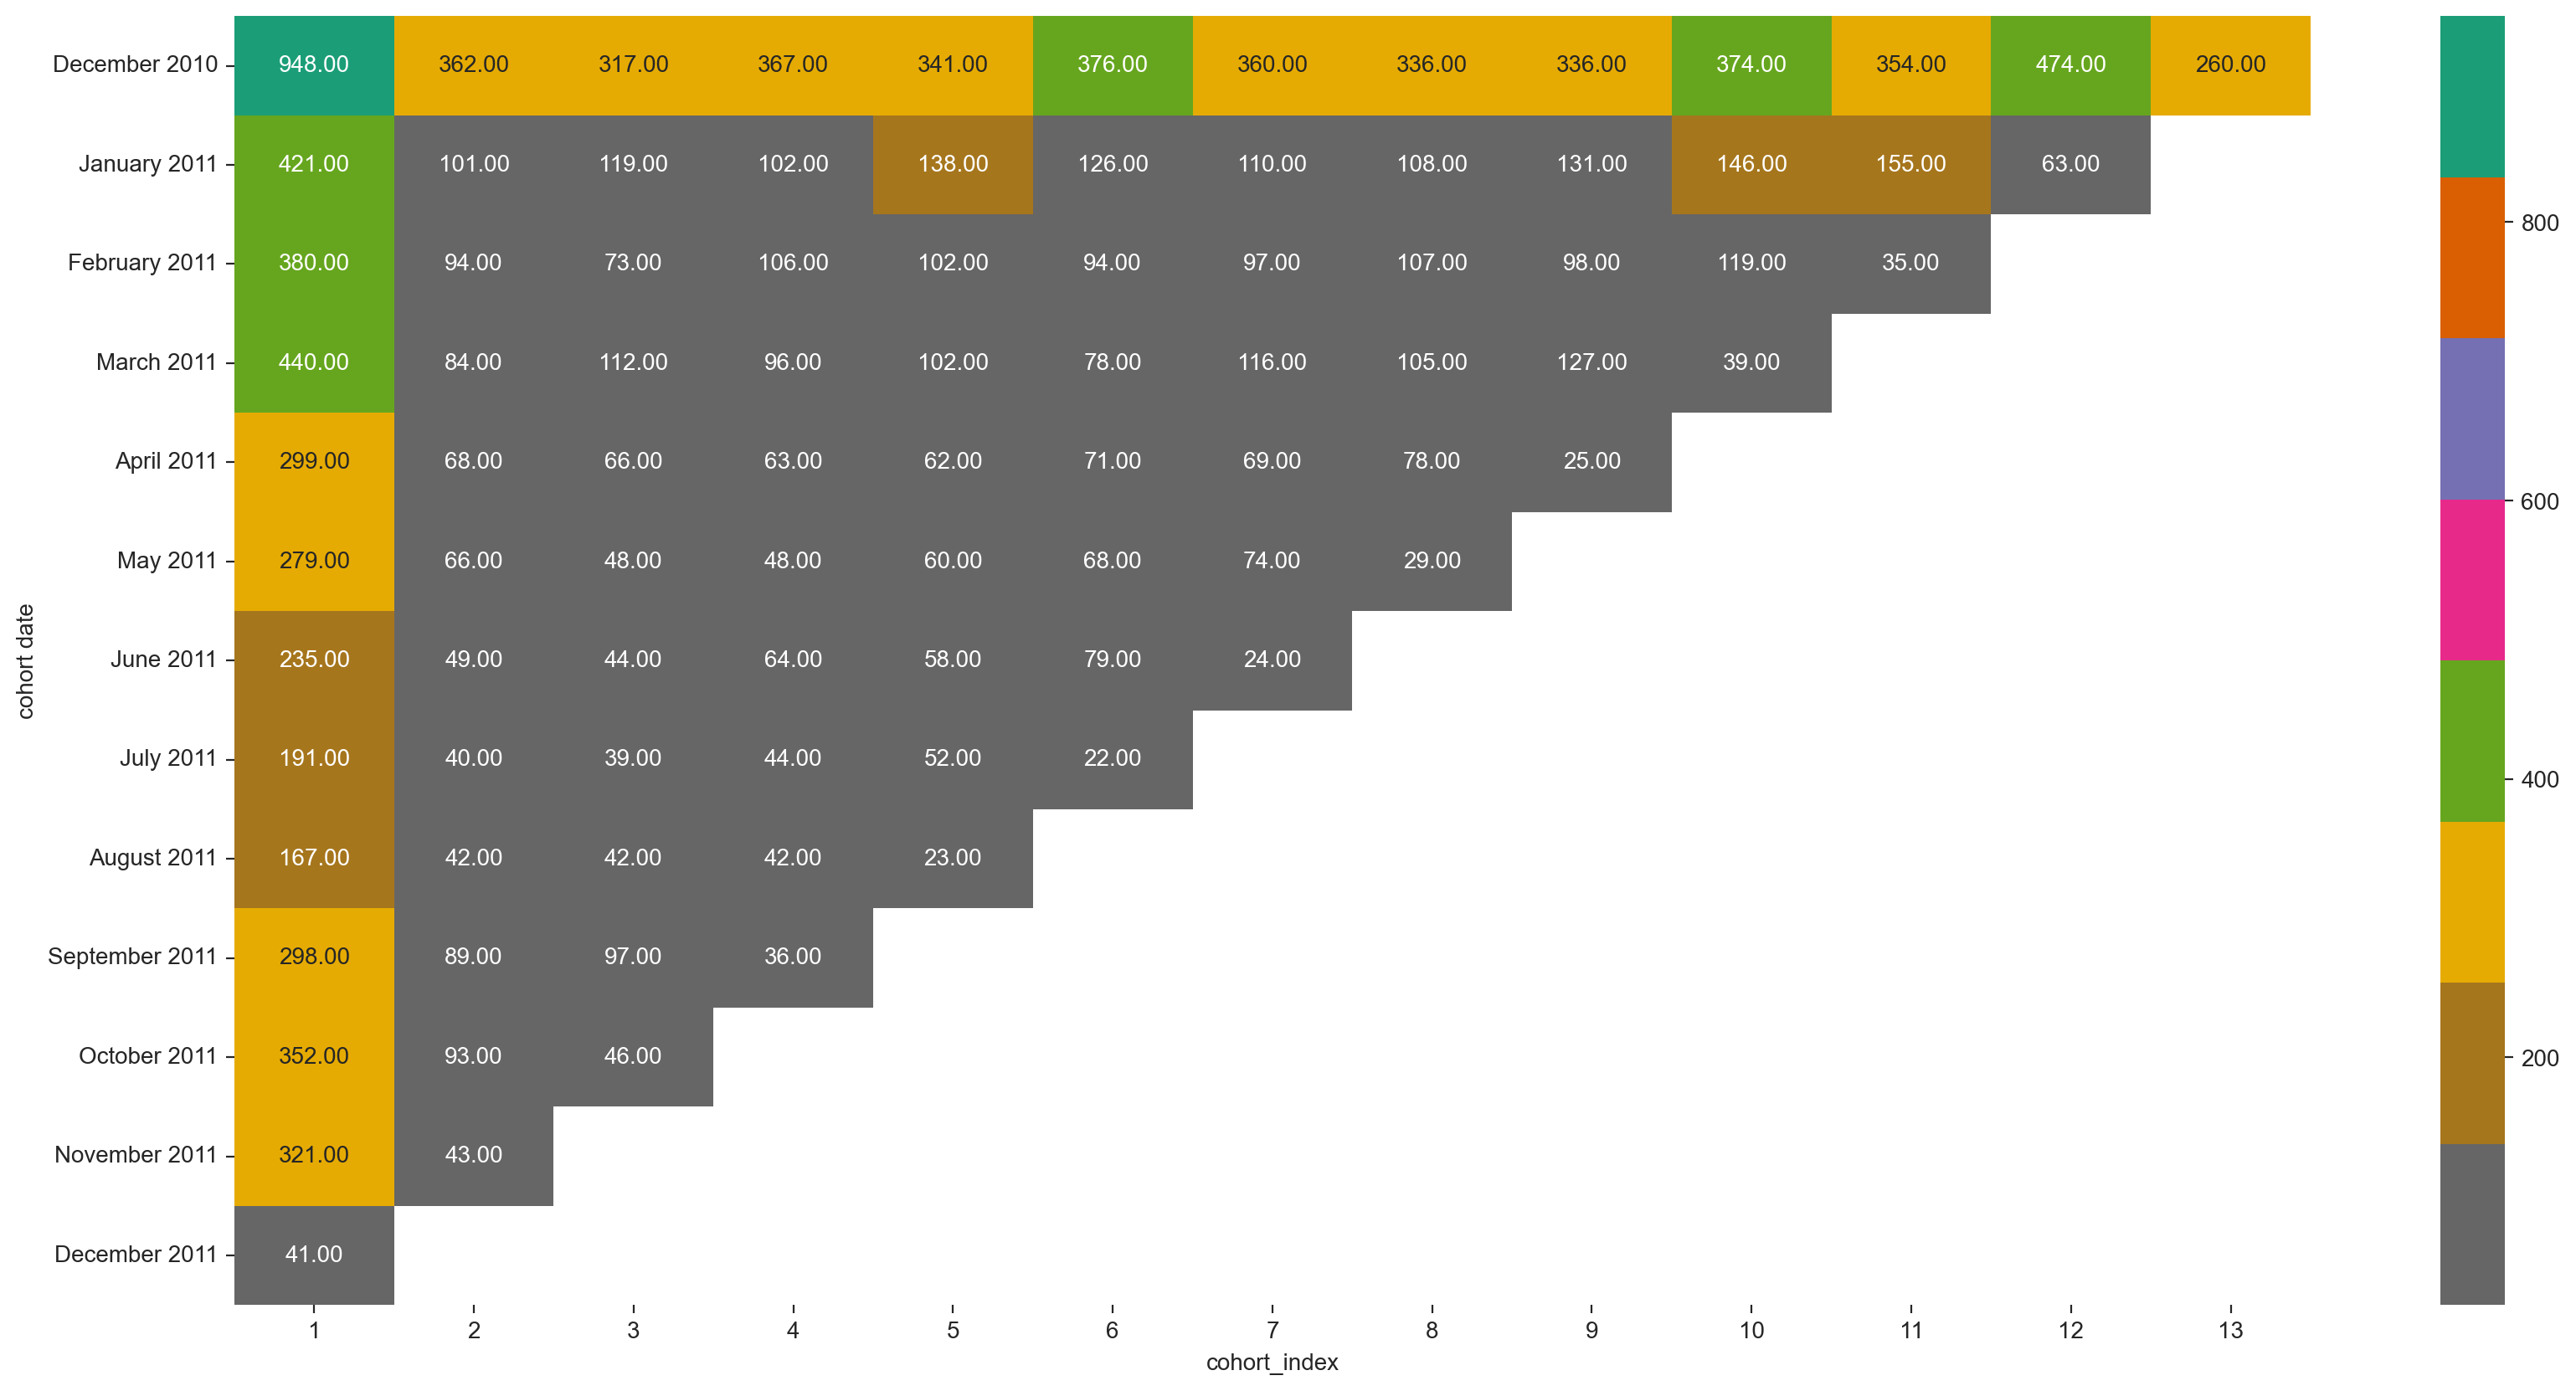

In [140]:
#visualize our results in heatmap

plt.figure(figsize = (20,10))
sns.heatmap(cohort_table, annot = True, cmap = 'Dark2_r', fmt = ".2f")

In [144]:
# showing retention rate in percentage
new_cohort_table = cohort_table.divide(cohort_table.iloc[:,0], axis = 0)
new_cohort_table

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort date,,,,,,,,,,,,,
December 2010,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
January 2011,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
February 2011,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
March 2011,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
April 2011,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
May 2011,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
June 2011,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
July 2011,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
August 2011,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
